In [ ]:
import pandas as pd
import numpy as np

import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
train_file = "./kaggle/brist1d/train.csv"
#test_file = "./kaggle/brist1d/test.csv"

df = pd.read_csv(train_file)
#df_test = pd.read_csv(test_file)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

df.dtypes

/tmp/ipykernel_27292/3541279535.py:4: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_file)


id               category
p_num            category
time             category
bg-5:55           float64
bg-5:50           float64
                   ...   
activity-0:15    category
activity-0:10    category
activity-0:05    category
activity-0:00    category
bg+1:00           float64
Length: 508, dtype: object

## Data Cleaning - handling missing values

In [3]:
features = df.columns
bg_cols = [col for col in features if "bg" in col]
insulin_cols = [col for col in features if "insulin" in col]
carbs_cols = [col for col in features if "carbs" in col]
hr_cols = [col for col in features if "hr" in col]
steps_cols = [col for col in features if "steps" in col]
cals_cols = [col for col in features if "cals" in col]
activity_cols = [col for col in features if "activity" in col]

Fill missing values for features based on:
- mean value: blood glucose, carbs, cals
- zeroes: insulin
- forward filled (i.e. propagates the last observation forward): heart rate, steps

In [4]:
for feature in [*bg_cols, *carbs_cols, *cals_cols]:
    df[feature] = df[feature].fillna(df[feature].mean())

for feature in insulin_cols:
    df[feature] = df[feature].fillna(0)

for feature in [*hr_cols, *steps_cols]:
    df[feature] = df[feature].fillna(method="ffill")

df.isna().sum()

id                    0
p_num                 0
time                  0
bg-5:55               0
bg-5:50               0
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64

In [6]:
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds()

# for now we just ignore participant profiles
df.drop(columns=["p_num", "id", *activity_cols], inplace=True)

# drop remaining NAs that could not be filled in
df = df.dropna(how="any")

y = df["bg+1:00"]
df = df.drop("bg+1:00", axis=1)



In [7]:
print("Data shape", df.shape)

Data shape (176712, 433)


### Normalize features

In [ ]:
# scale features
scaler = StandardScaler()
df = scaler.fit_transform(df)
y = scaler.fit_transform(np.reshape(y.values, (-1, 1)))

# transform to tensor and reshape
df_tensor = torch.Tensor(df)
y_tensor = torch.Tensor(y)
print(df_tensor.shape)
print(y_tensor.shape)

# create dataloader
dataset = torch.utils.data.TensorDataset(df_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)


torch.Size([176712, 433])
torch.Size([176712, 1])


#### Checking the data before feeding it into the network

In [9]:
print(df_tensor.isnan().any())
df_tensor

tensor(False)


tensor([[ 9.0299e-01, -2.3746e-08,  2.3834e+00,  ..., -3.1383e-02,
          5.9740e-01,  3.8216e-01],
        [ 9.3925e-01, -2.3746e-08,  2.3471e+00,  ...,  1.2733e-01,
          3.5520e-01,  4.8102e-02],
        [ 9.7552e-01, -2.3746e-08,  3.7406e-04,  ..., -4.4766e-01,
         -4.3542e-01,  2.3601e-01],
        ...,
        [ 1.7129e+00,  3.7665e-01,  4.2462e-01,  ..., -3.6552e-01,
         -3.6583e-01, -3.6530e-01],
        [ 1.7250e+00,  4.5281e-01,  5.6971e-01,  ..., -3.6552e-01,
         -3.6583e-01, -3.6530e-01],
        [ 1.7370e+00,  6.0515e-01,  7.1481e-01,  ..., -3.6552e-01,
         -3.6583e-01, -3.6530e-01]])

### RNN (LSTM)

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.activ = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.activ(out)
        pred = self.linear(out)

        return pred

model = RNN(input_size=df_tensor.size(1), hidden_size=64, num_layers=1)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.05)
mse_loss = torch.nn.MSELoss()

In [25]:
losses = []


for i in tqdm.tqdm(range(10)):
    loss = 0
    for j, (data, target) in tqdm.tqdm(enumerate(dataloader)):
        #print("Input data", data.shape, target.shape)
        optimizer.zero_grad()

        prediction = model.forward(data)
      
        #print("Pred, target", prediction[0], target[0], prediction.shape, target.shape)

        batch_loss = mse_loss(prediction, target)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.detach().item()
        #print("Loss:", batch_loss.detach().item())
    losses.append(loss)
    print("Loss:", losses[-1])

173it [00:15, 11.14it/s]0:00<?, ?it/s]
 10%|█         | 1/10 [00:15<02:19, 15.54s/it]

Loss: 97.17030563950539


173it [00:20,  8.24it/s]
 20%|██        | 2/10 [00:36<02:29, 18.75s/it]

Loss: 92.242511510849


173it [00:22,  7.64it/s]
 30%|███       | 3/10 [00:59<02:23, 20.53s/it]

Loss: 89.62916219234467


173it [00:24,  7.02it/s]
 40%|████      | 4/10 [01:23<02:12, 22.15s/it]

Loss: 87.88894778490067


173it [00:24,  6.96it/s]
 50%|█████     | 5/10 [01:48<01:55, 23.13s/it]

Loss: 86.41688764095306


173it [00:23,  7.33it/s]
 60%|██████    | 6/10 [02:12<01:33, 23.30s/it]

Loss: 85.25454092025757


173it [00:23,  7.21it/s]
 70%|███████   | 7/10 [02:36<01:10, 23.52s/it]

Loss: 84.60330033302307


173it [00:23,  7.35it/s]
 80%|████████  | 8/10 [02:59<00:47, 23.53s/it]

Loss: 84.34500339627266


173it [00:22,  7.73it/s]
 90%|█████████ | 9/10 [03:22<00:23, 23.18s/it]

Loss: 83.786042958498


173it [00:21,  8.10it/s]
100%|██████████| 10/10 [03:43<00:00, 22.36s/it]

Loss: 83.51233512163162


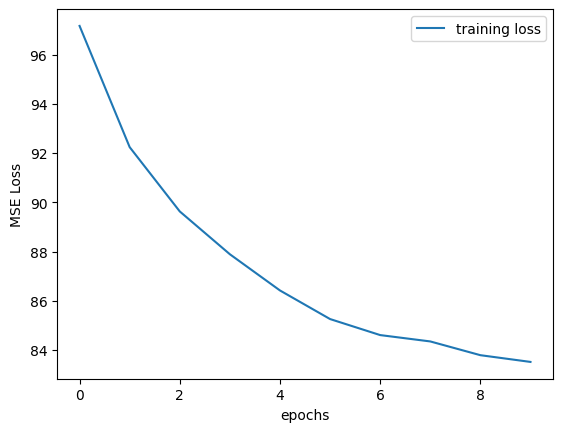

In [29]:
plt.plot(losses, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


### Make predictions and compute MSE

In [39]:
test_file = "./kaggle/brist1d/test.csv"
df_test = pd.read_csv(test_file)

X_test = df_test.drop(["p_num", "id", "time", *activity_cols], axis=1)
X_test = torch.Tensor(scaler.fit_transform(X_test))
print(X_test.shape)

torch.Size([3644, 432])


In [ ]:
from sklearn.metrics import mean_squared_error

# Make predictions
with torch.no_grad():
    y_test_pred = model(X_test)

print(y_test_pred)
print(df_test["id"].shape, y_test_pred.shape, type(y_test_pred))
out = np.column_stack([df_test["id"], y_test_pred])
out = pd.DataFrame(out, columns=["id", "bg+1:00"])

out.to_csv("submission.csv", index=False)

tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]])
(3644,) torch.Size([3644, 1]) <class 'torch.Tensor'>
